#  **Kolmogorov-Arnold Networks (KAN)**

## **¿Qué son las KAN?**

Las **Kolmogorov-Arnold Networks** son redes neuronales basadas en el teorema de Kolmogorov-Arnold:

$$f(x_1, ..., x_n) = \sum_{q=1}^{2n+1} \Phi_q \left( \sum_{p=1}^{n} \phi_{q,p}(x_p) \right)$$

**Idea clave:** Cualquier función continua multivariable puede descomponerse en **sumas y composiciones de funciones univariadas**.

---

## **En este notebook:**

 **Usamos B-SPLINES reales** (funciones polinomiales por tramos aprendibles)

**B-Splines:**
- Funciones suaves definidas por **knots** (nodos) y **coeficientes**
- Diferenciables → entrenables con backpropagation
- Cada rama aprende una función $g_i(a_i^T x)$ donde:
  - $a_i^T x$ = proyección lineal
  - $g_i$ = B-spline con coeficientes aprendibles

---

## **Arquitectura :**
```
Input (784 dim)
    ↓
K proyecciones lineales: a_i^T x + b_i
    ↓
K B-splines: g_i(proyección_i)
    ↓
Suma: Σ g_i(a_i^T x)
    ↓
Capa final (10 clases)
```

**Hiperparámetros:**
- K = 48 ramas (ajustable)
- Grado de spline = 3 (cúbicos)
- Número de knots = 8
- Batch size = 128
- Épocas = 35 (modo completo)

---



In [1]:
# ==============================================================================
# CONFIGURACIÓN
# ==============================================================================


MODO = "COMPLETO"

if MODO == "RAPIDO":

    K_BRANCHES = 32

    NUM_EPOCHS = 10

    NUM_KNOTS = 6

    BATCH_SIZE = 128

    DROPOUT_RATE = 0.2

    WEIGHT_DECAY = 1e-5

    EARLY_STOP_PATIENCE = 6

    USE_SCHEDULER = False

    print(" MODO RÁPIDO activado")
    print(f" - {K_BRANCHES} ramas")
    print(f" - {NUM_EPOCHS} épocas")

else:  # MODO == "COMPLETO"

    K_BRANCHES = 48

    NUM_EPOCHS = 35

    NUM_KNOTS = 8

    BATCH_SIZE = 128

    DROPOUT_RATE = 0.3

    WEIGHT_DECAY = 1e-4

    EARLY_STOP_PATIENCE = 10

    # Learning Rate Scheduler
    ## Activa el scheduler que reduce el learning rate cuando el progreso se estanca
    USE_SCHEDULER = True
    ## Épocas sin mejora antes de reducir el learning rate
    SCHEDULER_PATIENCE = 3
    ## Factor de reducción del learning rate (lo reduce a la mitad)
    SCHEDULER_FACTOR = 0.5
    ## Learning rate mínimo permitido - evita que sea demasiado pequeño
    MIN_LR = 1e-6


    # Gradient Clipping
    ## Activa el recorte de gradientes para evitar explosión de gradientes
    USE_GRAD_CLIP = True
    ## Norma máxima permitida para los gradientes - valores más altos se escalan
    MAX_GRAD_NORM = 1.0

    # Warmup
    ## Activa el warmup - aumenta gradualmente el learning rate al inicio
    USE_WARMUP = True
    ## Número de épocas con warmup para estabilizar el entrenamiento inicial
    WARMUP_EPOCHS = 3


    print("MODO COMPLETO ")
    print(f" - {K_BRANCHES} ramas KAN")
    print(f" - {NUM_EPOCHS} épocas máximas")
    print(f" - Early Stop: {EARLY_STOP_PATIENCE} épocas")
    print(f" - Dropout: {DROPOUT_RATE}")
    print(f" - Weight Decay: {WEIGHT_DECAY}")

# Otros hiperparámetros
## Grado de los polinomios spline - 3 = splines cúbicos (suaves y continuos)
SPLINE_DEGREE = 3
## Tasa de aprendizaje inicial del optimizador
LEARNING_RATE = 0.001
## Porcentaje del dataset de entrenamiento usado para validación (10%)
VAL_SPLIT = 0.1
## Número de clases en el problema de clasificación (10 para MNIST)
NUM_CLASSES = 10


print(f"\n Configuración:")
print(f" - Grado spline: {SPLINE_DEGREE} (cúbicos)")
print(f" - Knots: {NUM_KNOTS}")
print(f" - Batch size: {BATCH_SIZE}")
print(f" - Learning rate: {LEARNING_RATE}")

MODO COMPLETO 
 - 48 ramas KAN
 - 35 épocas máximas
 - Early Stop: 10 épocas
 - Dropout: 0.3
 - Weight Decay: 0.0001

 Configuración:
 - Grado spline: 3 (cúbicos)
 - Knots: 8
 - Batch size: 128
 - Learning rate: 0.001


In [2]:
# ==============================================================================
#  3: Verificación del entorno y GPU
# ==============================================================================

import torch
import os

print("="*70)
print(" VERIFICACIÓN DEL ENTORNO")
print("="*70)

# Verificar PyTorch
print(f" PyTorch versión: {torch.__version__}")

# Detectar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Dispositivo detectado: {device}")

# Si hay GPU, mostrar detalles
if torch.cuda.is_available():
    print(f" GPU: {torch.cuda.get_device_name(0)}")
    print(f" Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # Ejecutar nvidia-smi para ver estado de la GPU
    print("\n Estado de la GPU (nvidia-smi):")
    os.system('nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv')

    # Habilitar optimizaciones
    torch.backends.cudnn.benchmark = True
    print("\n cuDNN benchmark habilitado")
else:
    print("  No se detectó GPU. Entrenamiento será en CPU (MUY lento)")
    print("   Recomendación: En Colab, ve a Runtime → Change runtime type → GPU")

print("="*70)

 VERIFICACIÓN DEL ENTORNO
 PyTorch versión: 2.8.0+cu126
 Dispositivo detectado: cuda
 GPU: Tesla T4
 Memoria total: 15.83 GB

 Estado de la GPU (nvidia-smi):

 cuDNN benchmark habilitado


In [3]:
# ==============================================================================
#  4: Instalación de dependencias
# ==============================================================================

print(" Instalando dependencias...\n")

# Intentamos instalar pykan (oficial)
print("Intentando instalar pykan oficial...")
install_result = os.system('pip install pykan 2>&1 | tail -5')

if install_result != 0:
    print("\n  pykan no disponible o falló instalación")
    print(" Usaremos implementación propia de B-splines (incluida en este notebook)")
    USE_CUSTOM_SPLINES = True
else:
    print("\n pykan instalado correctamente")
    USE_CUSTOM_SPLINES = False  # Usaremos pykan si está disponible

# Instalar otras dependencias necesarias
print("\nInstalando bibliotecas auxiliares...")
os.system('pip install matplotlib seaborn scikit-learn tqdm')

print("\n Todas las dependencias instaladas")

 Instalando dependencias...

Intentando instalar pykan oficial...

 pykan instalado correctamente

Instalando bibliotecas auxiliares...

 Todas las dependencias instaladas


In [4]:
# ==============================================================================
#  5: Importación de bibliotecas
# ==============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import time
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)
sns.set_palette("husl")

print(" Todas las bibliotecas importadas correctamente")


 Todas las bibliotecas importadas correctamente


#  **Implementación de B-Splines en PyTorch**

## **¿Qué son los B-Splines?**

Los **B-splines** (basis splines) son funciones polinomiales por tramos que forman una base para aproximar funciones suaves.

**Definición matemática:**

Un B-spline de grado $k$ con knots $t_0, t_1, ..., t_m$ se define recursivamente:

$$B_{i,0}(x) = \begin{cases} 1 & \text{si } t_i \leq x < t_{i+1} \\ 0 & \text{sino} \end{cases}$$

$$B_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} B_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} B_{i+1,k-1}(x)$$

**Función aproximada:**

$$g(x) = \sum_{i=1}^{n} c_i \cdot B_{i,k}(x)$$

donde $c_i$ son **coeficientes aprendibles** (parámetros del modelo).

---

## **Nuestra implementación:**

- **Knots:** Espaciados uniformemente en $[-1, 1]$
- **Grado:** 3 (splines cúbicos = suaves)
- **Coeficientes:** Vectores de parámetros entrenables
- **Diferenciable:** Totalmente compatible con autograd de PyTorch

La clase `BSplineBasis` calcula las funciones base y la clase `UnivariateSpline` las combina con coeficientes aprendibles.

In [5]:
# ==============================================================================
#  7: Implementación de B-Splines en PyTorch
# ==============================================================================

class BSplineBasis:
    """
    Calcula las funciones base de B-splines de forma vectorizada.

    Esta clase implementa el algoritmo de De Boor para evaluar B-splines.

    Args:
        num_knots (int): Número de knots internos
        degree (int): Grado del spline (3 = cúbico)
        x_min (float): Límite inferior del dominio
        x_max (float): Límite superior del dominio
    """
    def __init__(self, num_knots=8, degree=3, x_min=-1.0, x_max=1.0):
        self.degree = degree
        self.num_knots = num_knots

        # Creamos la secuencia de knots extendida
        # Incluye knots repetidos en los extremos para condiciones de frontera
        # Estructura: [x_min repetido (degree+1) veces] + [knots internos] + [x_max repetido (degree+1) veces]
        internal_knots = torch.linspace(x_min, x_max, num_knots)

        # Knots repetidos al inicio
        left_knots = torch.ones(degree) * x_min
        # Knots repetidos al final
        right_knots = torch.ones(degree) * x_max

        # Concatenamos: [left, internal, right]
        self.knots = torch.cat([left_knots, internal_knots, right_knots])

        # Número total de funciones base
        # Para degree k y m knots, tenemos (m + k - 1) funciones base
        self.num_bases = len(self.knots) - degree - 1

    def __call__(self, x, device='cuda'):
        """
        Evalúa todas las funciones base de B-spline en los puntos x.

        Args:
            x: tensor de shape (batch_size,) con valores en [x_min, x_max]
            device: dispositivo (cuda/cpu)

        Returns:
            tensor de shape (batch_size, num_bases) con valores de las bases
        """
        # Movemos knots al dispositivo correcto
        knots = self.knots.to(device)

        # x shape: (batch_size,)
        batch_size = x.shape[0]

        # Aseguramos que x esté en el rango correcto (clipping)
        # Esto evita problemas numéricos fuera del dominio
        x = torch.clamp(x, knots[0], knots[-1])

        # Inicializamos las bases de orden 0 (funciones indicadoras)
        # B_{i,0}(x) = 1 si knots[i] <= x < knots[i+1], 0 sino
        # Shape: (batch_size, num_bases + degree)
        bases = torch.zeros(batch_size, len(knots) - 1, device=device)

        # Para cada punto x, encontramos en qué intervalo cae
        for i in range(len(knots) - 1):
            # Máscara: True si x está en [knots[i], knots[i+1])
            mask = (x >= knots[i]) & (x < knots[i + 1])
            bases[:, i] = mask.float()

        # Caso especial: último knot (x == x_max)
        # Activamos la última base para evitar que quede fuera
        last_knot_mask = (x == knots[-1])
        if last_knot_mask.any():
            bases[last_knot_mask, -1] = 1.0

        # Recursión de De Boor: calculamos bases de orden superior
        # Iteramos desde orden 1 hasta 'degree'
        for k in range(1, self.degree + 1):
            # Número de bases activas en este nivel
            num_bases_k = len(knots) - k - 1

            # Nuevas bases de orden k
            new_bases = torch.zeros(batch_size, num_bases_k, device=device)

            for i in range(num_bases_k):
                # Índices de knots para esta base
                left_knot = knots[i]
                right_knot = knots[i + k]
                next_left_knot = knots[i + 1]
                next_right_knot = knots[i + k + 1]

                # Primer término de la recursión
                denom1 = right_knot - left_knot
                if denom1 > 1e-6:  # Evitar división por cero
                    w1 = (x - left_knot) / denom1
                    term1 = w1 * bases[:, i]
                else:
                    term1 = 0.0

                # Segundo término de la recursión
                denom2 = next_right_knot - next_left_knot
                if denom2 > 1e-6:
                    w2 = (next_right_knot - x) / denom2
                    term2 = w2 * bases[:, i + 1]
                else:
                    term2 = 0.0

                # Suma de ambos términos
                new_bases[:, i] = term1 + term2

            # Actualizamos bases para la próxima iteración
            bases = new_bases

        # bases shape: (batch_size, num_bases)
        return bases


class UnivariateSpline(nn.Module):
    """
    Función univariada aprendible implementada con B-splines.

    Esta es la función g_i(x) = Σ c_i * B_i(x) donde:
    - B_i(x) son las funciones base de B-spline (fijas)
    - c_i son coeficientes aprendibles (parámetros del modelo)

    Args:
        num_knots (int): Número de knots
        degree (int): Grado del spline
        x_min, x_max (float): Rango del dominio
    """
    def __init__(self, num_knots=8, degree=3, x_min=-3.0, x_max=3.0):
        super(UnivariateSpline, self).__init__()

        # Creamos el evaluador de funciones base
        self.basis = BSplineBasis(num_knots, degree, x_min, x_max)

        # Coeficientes aprendibles (parámetros del modelo)
        # Inicializamos con distribución normal pequeña
        self.coeffs = nn.Parameter(
            torch.randn(self.basis.num_bases) * 0.1
        )

        # Guardamos rango para normalización
        self.x_min = x_min
        self.x_max = x_max

    def forward(self, x):
        """
        Evalúa la función spline en los puntos x.

        Args:
            x: tensor de shape (batch_size,)

        Returns:
            tensor de shape (batch_size,) con g(x)
        """
        # x shape: (batch_size,)

        # Normalizamos x al rango [x_min, x_max]
        # Esto asegura estabilidad numérica
        x_normalized = torch.clamp(x, self.x_min, self.x_max)

        # Evaluamos las funciones base: (batch_size, num_bases)
        basis_values = self.basis(x_normalized, device=x.device)

        # Multiplicamos por coeficientes y sumamos
        # (batch_size, num_bases) @ (num_bases,) → (batch_size,)
        output = torch.matmul(basis_values, self.coeffs)

        return output


print("="*70)
print(" IMPLEMENTACIÓN DE B-SPLINES COMPLETADA")
print("="*70)
print(f" Clase BSplineBasis: Evalúa funciones base de B-splines")
print(f" Clase UnivariateSpline: Función aprendible g(x) = Σ c_i * B_i(x)")
print(f"\n Configuración:")
print(f"   - Grado: {SPLINE_DEGREE} (splines cúbicos)")
print(f"   - Knots: {NUM_KNOTS}")
print(f"   - Dominio: [-3, 3] (se normaliza automáticamente)")
print("="*70)

 IMPLEMENTACIÓN DE B-SPLINES COMPLETADA
 Clase BSplineBasis: Evalúa funciones base de B-splines
 Clase UnivariateSpline: Función aprendible g(x) = Σ c_i * B_i(x)

 Configuración:
   - Grado: 3 (splines cúbicos)
   - Knots: 8
   - Dominio: [-3, 3] (se normaliza automáticamente)


#  **Arquitectura KAN con B-Splines**

## **Ecuación del modelo:**

$$f(x) = \text{Softmax}\left( W \cdot \left[ \sum_{i=1}^{K} g_i(a_i^T x + b_i) \right] + c \right)$$

Donde:
- $x \in \mathbb{R}^{784}$ = imagen aplanada
- $a_i \in \mathbb{R}^{784}$, $b_i \in \mathbb{R}$ = proyección lineal de la rama $i$
- $g_i$ = B-spline con coeficientes aprendibles
- $K$ = número de ramas
- $W \in \mathbb{R}^{10 \times K}$, $c \in \mathbb{R}^{10}$ = capa final

## **Flujo de datos:**
```
Input: (batch, 784)
    ↓
K proyecciones: a_i^T x + b_i  →  (batch, K)
    ↓
K splines: g_i(proyección_i)  →  (batch, K)
    ↓
Capa lineal: W @ splines + c  →  (batch, 10)
    ↓
Softmax (en loss)  →  Probabilidades
```

## **Parámetros entrenables:**

1. **Proyecciones:** K × (784 + 1) = K × 785
2. **Coeficientes splines:** K × num_bases
3. **Capa final:** 10 × K + 10

**Total aproximado:** ~40k-60k parámetros (depende de K)

In [6]:
# ==============================================================================
#  9: Arquitectura KAN completa
# ==============================================================================

class KANLayer(nn.Module):
    """
    Capa KAN: implementa f(x) = Σ g_i(a_i^T x + b_i)

    Cada rama tiene:
    - Proyección lineal: a_i^T x + b_i
    - Función univariada: g_i (B-spline aprendible)

    Args:
        input_dim (int): Dimensión de entrada (784 para MNIST)
        num_branches (int): Número de ramas K
        num_knots (int): Knots por spline
        degree (int): Grado de los splines
    """
    def __init__(self, input_dim=784, num_branches=48, num_knots=8, degree=3):
        super(KANLayer, self).__init__()

        self.input_dim = input_dim
        self.num_branches = num_branches

        # Proyecciones lineales: una por rama
        # Cada proyección: R^784 → R (escalar)
        # Parámetros: a_i (weight) y b_i (bias)
        self.projections = nn.Linear(input_dim, num_branches)

        # Funciones univariadas (B-splines): una por rama
        # Cada spline tiene sus propios coeficientes aprendibles
        self.splines = nn.ModuleList([
            UnivariateSpline(num_knots=num_knots, degree=degree)
            for _ in range(num_branches)
        ])

    def forward(self, x):
        """
        Forward pass de la capa KAN.

        Args:
            x: tensor (batch_size, input_dim)

        Returns:
            tensor (batch_size, num_branches)
        """
        # x shape: (batch, 784)

        # Paso 1: Proyecciones lineales
        # (batch, 784) @ (784, K) → (batch, K)
        projections = self.projections(x)
          # normalizar con tanh para estabilidad
        projections = torch.tanh(projections)
        # Paso 2: Aplicar splines a cada proyección
        # Necesitamos iterar porque cada spline tiene sus propios parámetros
        spline_outputs = []

        for i in range(self.num_branches):
            # Extraemos proyección de la rama i: (batch,)
            proj_i = projections[:, i]

            # Aplicamos el spline g_i: (batch,) → (batch,)
            spline_i = self.splines[i](proj_i)

            spline_outputs.append(spline_i)

        # Apilamos salidas: K tensores (batch,) → (batch, K)
        output = torch.stack(spline_outputs, dim=1)

        return output


class KANClassifier(nn.Module):
    """
    Clasificador KAN completo para MNIST.

    Arquitectura:
        Input (28×28) → Flatten (784) → KANLayer (K) → Linear (10) → Softmax

    Args:
        num_branches (int): Número de ramas K
        num_knots (int): Knots por spline
        degree (int): Grado de splines
        num_classes (int): Número de clases (10 para MNIST)
    """
    def __init__(self, num_branches=48, num_knots=8, degree=3, num_classes=10):
        super(KANClassifier, self).__init__()

        # Capa KAN principal
        self.kan_layer = KANLayer(
            input_dim=784,
            num_branches=num_branches,
            num_knots=num_knots,
            degree=degree
        )
         # (10%)
        #self.dropout = nn.Dropout(0.1)#  se apagan al azar
        # de 0.1 a DROPOUT_RATE
        self.dropout = nn.Dropout(DROPOUT_RATE)  # Era 0.1, ahora 0.3

        # Capa de clasificación final
        # (batch, K) → (batch, 10)
        self.classifier = nn.Linear(num_branches, num_classes)

    def forward(self, x):
        """
        Forward pass completo.

        Args:
            x: tensor (batch, 1, 28, 28)

        Returns:
            tensor (batch, 10) - logits
        """
        # x shape: (batch, 1, 28, 28)

        # Aplanamos la imagen
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # (batch, 784)

        # Pasamos por KAN layer
        x = self.kan_layer(x)  # (batch, K)
        # Dropout más agresivo
        x = self.dropout(x)
        # Clasificación final
        x = self.classifier(x)  # (batch, 10)

        return x  # Logits (softmax se aplica en la loss)


# Función auxiliar para contar parámetros
def count_parameters(model):
    """Cuenta parámetros entrenables del modelo."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print("="*70)
print(" ARQUITECTURA KAN DEFINIDA")
print("="*70)
print(f" KANLayer: {K_BRANCHES} ramas con B-splines")
print(f" Cada rama: proyección lineal + spline ({NUM_KNOTS} knots, grado {SPLINE_DEGREE})")
print(f" Clasificador: KAN → Linear(10)")
print("="*70)

 ARQUITECTURA KAN DEFINIDA
 KANLayer: 48 ramas con B-splines
 Cada rama: proyección lineal + spline (8 knots, grado 3)
 Clasificador: KAN → Linear(10)


In [7]:
# ==============================================================================
#  10: Prueba - Verificación de shapes
# ==============================================================================

print(" PRUEBA : Verificando shapes del modelo\n")

# Creamos modelo temporal
test_model = KANClassifier(
    num_branches=K_BRANCHES,
    num_knots=NUM_KNOTS,
    degree=SPLINE_DEGREE
).to(device)

# Batch aleatorio de prueba
test_batch = torch.randn(16, 1, 28, 28).to(device)

print(f" Input shape: {test_batch.shape}")

# Forward pass
with torch.no_grad():
    test_output = test_model(test_batch)

print(f" Output shape: {test_output.shape}")
print(f" Esperado: (16, 10) ← {'✓ CORRECTO' if test_output.shape == (16, 10) else '✗ ERROR'}")

# Contamos parámetros
num_params = count_parameters(test_model)
print(f"\n Parámetros totales: {num_params:,}")

# Limpiamos memoria
del test_model, test_batch, test_output
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("\n Prueba completada exitosamente")

 PRUEBA : Verificando shapes del modelo

 Input shape: torch.Size([16, 1, 28, 28])
 Output shape: torch.Size([16, 10])
 Esperado: (16, 10) ← ✓ CORRECTO

 Parámetros totales: 38,650

 Prueba completada exitosamente


In [8]:
# ==============================================================================
#  11: Descarga y preparación del dataset MNIST
# ==============================================================================

# Transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte a tensor [0, 1]
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliza con media y std de MNIST
])

# Descargamos datasets
print(" Descargando MNIST...")
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f" Train: {len(train_dataset):,} imágenes")
print(f" Test: {len(test_dataset):,} imágenes")

# División train/validation
train_size = int((1 - VAL_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f" Validación: {val_size:,} imágenes ({VAL_SPLIT*100:.0f}%)")

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n DataLoaders creados (batch_size={BATCH_SIZE})")

 Descargando MNIST...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]

 Train: 60,000 imágenes
 Test: 10,000 imágenes
 Validación: 6,000 imágenes (10%)

 DataLoaders creados (batch_size=128)


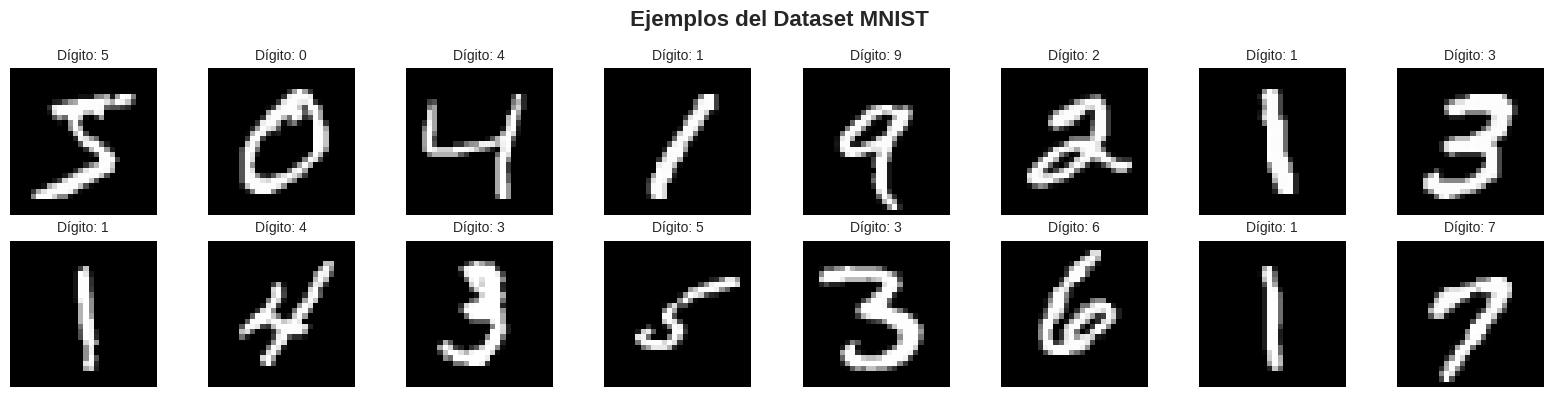

 Visualización de ejemplos completada


In [9]:
# ==============================================================================
#  12: Visualización de ejemplos del dataset
# ==============================================================================

# Creamos una figura con grid de 2 filas x 8 columnas
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle(' Ejemplos del Dataset MNIST', fontsize=16, fontweight='bold')

# Iteramos sobre 16 imágenes
for i in range(16):
    # Calculamos posición en el grid
    row = i // 8  # Fila (0 o 1)
    col = i % 8   # Columna (0-7)
    ax = axes[row, col]  # Seleccionamos el subplot

    # Obtenemos imagen y etiqueta del dataset
    img, label = train_dataset[i]

    # Convertimos tensor a numpy: (1, 28, 28) → (28, 28)
    img_np = img.squeeze().numpy()

    # Mostramos la imagen en escala de grises
    ax.imshow(img_np, cmap='gray')

    # Título con la etiqueta verdadera
    ax.set_title(f'Dígito: {label}', fontsize=10)

    # Quitamos ejes para visualización limpia
    ax.axis('off')

# Ajustamos espaciado entre subplots
plt.tight_layout()

# Mostramos la figura
plt.show()

print(" Visualización de ejemplos completada")

In [10]:
# ==============================================================================
#  13: Inicialización del modelo, optimizador y configuración
# ==============================================================================

print("="*70)
print(" INICIALIZANDO MODELO")
print("="*70)

# Creamos el modelo KAN
model = KANClassifier(
    num_branches=K_BRANCHES,      # Número de ramas
    num_knots=NUM_KNOTS,          # Knots por spline
    degree=SPLINE_DEGREE,         # Grado de splines (3 = cúbicos)
    num_classes=NUM_CLASSES       # 10 clases (dígitos 0-9)
).to(device)  # Movemos a GPU/CPU

# Contamos parámetros del modelo
total_params = count_parameters(model)
print(f" Parámetros entrenables: {total_params:,}")

# Calculamos parámetros por componente
projection_params = K_BRANCHES * (784 + 1)  # Proyecciones lineales
spline_params = K_BRANCHES * model.kan_layer.splines[0].basis.num_bases  # Coeficientes de splines
classifier_params = K_BRANCHES * NUM_CLASSES + NUM_CLASSES  # Capa final

print(f"\n Desglose de parámetros:")
print(f"   - Proyecciones: {projection_params:,}")
print(f"   - Splines: {spline_params:,}")
print(f"   - Clasificador: {classifier_params:,}")

# Definimos el optimizador Adam
# Adam es adaptativo y funciona bien en la mayoría de casos
optimizer = torch.optim.AdamW(
    model.parameters(),           # Parámetros a optimizar
    lr=LEARNING_RATE,             # Tasa de aprendizaje
    weight_decay=WEIGHT_DECAY    # # Regularización L2 (evita overfitting)
)

# Definimos función de pérdida
# CrossEntropyLoss combina LogSoftmax + NLLLoss
# Recibe logits (salida cruda del modelo) y etiquetas
criterion = nn.CrossEntropyLoss()

# Añadimos: Learning Rate Scheduler
if USE_SCHEDULER:
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',              # Maximizar accuracy
        factor=SCHEDULER_FACTOR,
        patience=SCHEDULER_PATIENCE,
        #verbose=True,
        min_lr=MIN_LR
    )
    print(f"\n Scheduler activado:")
    print(f"   - Factor: {SCHEDULER_FACTOR}")
    print(f"   - Paciencia: {SCHEDULER_PATIENCE}")

# Configuramos GradScaler para mixed precision training
# Escala los gradientes para evitar underflow en FP16
use_amp = torch.cuda.is_available()  # Solo si hay GPU
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print(f"\n Configuración de entrenamiento:")
print(f"   - Optimizador: Adam (lr={LEARNING_RATE})")
print(f"   - Loss: CrossEntropyLoss")
print(f"   - Mixed precision: {' Habilitado' if use_amp else ' Solo CPU'}")
print(f"   - Dispositivo: {device}")

# Variables para early stopping
best_val_acc = 0.0           # Mejor accuracy de validación
patience_counter = 0         # Contador de épocas sin mejora
patience = EARLY_STOP_PATIENCE  # Ahora es 6 en lugar de 3
min_delta = 0.001            # Mejora mínima para considerar progreso

# Historial de entrenamiento
history = {
    'train_loss': [],      # Pérdida de entrenamiento por época
    'val_loss': [],        # Pérdida de validación por época
    'train_acc': [],       # Accuracy de entrenamiento por época
    'val_acc': [],         # Accuracy de validación por época
    'epoch_times': []  ,    # Tiempo por época
    'learning_rates': []  # Añadir para monitorear LR

    }

print(f"\n Early stopping configurado:")
print(f"   - Paciencia: {patience} épocas")
print(f"   - Delta mínimo: {min_delta}")

print("="*70)
print()

 INICIALIZANDO MODELO
 Parámetros entrenables: 38,650

 Desglose de parámetros:
   - Proyecciones: 37,680
   - Splines: 480
   - Clasificador: 490

 Scheduler activado:
   - Factor: 0.5
   - Paciencia: 3

 Configuración de entrenamiento:
   - Optimizador: Adam (lr=0.001)
   - Loss: CrossEntropyLoss
   - Mixed precision:  Habilitado
   - Dispositivo: cuda

 Early stopping configurado:
   - Paciencia: 10 épocas
   - Delta mínimo: 0.001



/tmp/ipython-input-761181033.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [11]:
# ==============================================================================
# 16: Montaje de Google Drive
# ==============================================================================

try:
    # Intentamos montar Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Definimos rutas en Drive
    DRIVE_BASE = '/content/drive/MyDrive/KAN_MNIST_Real'
    CHECKPOINT_DIR = f'{DRIVE_BASE}/checkpoints'
    PLOTS_DIR = f'{DRIVE_BASE}/plots'

    # Creamos carpetas si no existen
    import os
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)

    USE_DRIVE = True
    print(" Google Drive montado correctamente")
    print(f" Checkpoints: {CHECKPOINT_DIR}")
    print(f" Gráficas: {PLOTS_DIR}")

except Exception as e:
    # Si falla (no estamos en Colab o usuario canceló)
    print(f"  No se pudo montar Drive: {e}")
    print(" Usando almacenamiento local (se perderá al cerrar sesión)")

    CHECKPOINT_DIR = './checkpoints'
    PLOTS_DIR = './plots'

    # Creamos carpetas locales
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)

    USE_DRIVE = False

print(f"\n Guardado en Drive: {' Habilitado' if USE_DRIVE else ' Solo local'}")

Mounted at /content/drive
 Google Drive montado correctamente
 Checkpoints: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints
 Gráficas: /content/drive/MyDrive/KAN_MNIST_Real/plots

 Guardado en Drive:  Habilitado


In [12]:
# ==============================================================================
#  17: Funciones para guardar y cargar checkpoints
# ==============================================================================

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, train_acc, val_acc, filename):
    """
    Guarda un checkpoint completo del entrenamiento.

    Args:
        model: modelo de PyTorch
        optimizer: optimizador
        epoch: número de época actual
        train_loss: pérdida de entrenamiento
        val_loss: pérdida de validación
        train_acc: accuracy de entrenamiento
        val_acc: accuracy de validación
        filename: ruta donde guardar
    """
    # Creamos diccionario con todo el estado
    checkpoint = {
        'epoch': epoch,                                  # Época actual
        'model_state_dict': model.state_dict(),          # Pesos del modelo
        'optimizer_state_dict': optimizer.state_dict(),  # Estado del optimizador
        'train_loss': train_loss,                        # Métricas
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'history': history,                              # Historial completo
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  # Fecha
        'config': {                                      # Configuración del modelo
            'K_BRANCHES': K_BRANCHES,
            'NUM_KNOTS': NUM_KNOTS,
            'SPLINE_DEGREE': SPLINE_DEGREE,
            'BATCH_SIZE': BATCH_SIZE,
            'LEARNING_RATE': LEARNING_RATE
        }
    }

    # Guardamos el checkpoint
    torch.save(checkpoint, filename)

    # Mensaje de confirmación
    print(f"    Checkpoint guardado: {filename}")


def load_checkpoint(model, optimizer, filename):
    """
    Carga un checkpoint previamente guardado.

    Args:
        model: modelo de PyTorch
        optimizer: optimizador
        filename: ruta del checkpoint

    Returns:
        int: época desde la cual continuar
    """
    # Cargamos el checkpoint
    # map_location asegura que funcione independiente del dispositivo
    checkpoint = torch.load(filename, map_location=device)

    # Restauramos estado del modelo
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restauramos estado del optimizador
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Recuperamos época
    start_epoch = checkpoint['epoch'] + 1  # Continuamos desde la siguiente

    # Restauramos historial si existe
    global history
    # if 'history' in checkpoint:
    #     history = checkpoint['history']
    if 'history' in checkpoint:
        history = checkpoint['history']
    #  Aseguramos que tenga todas las claves necesarias
        history.setdefault('learning_rates', [])
        history.setdefault('epoch_times', [])
        history.setdefault('train_loss', [])
        history.setdefault('val_loss', [])
        history.setdefault('train_acc', [])
        history.setdefault('val_acc', [])
    else:
        history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'epoch_times': [],
        'learning_rates': []
    }


    # Mensaje de confirmación
    print(f" Checkpoint cargado desde época {checkpoint['epoch']}")
    print(f"   Val Acc: {checkpoint['val_acc']:.4f}")

    return start_epoch


print(" Funciones de checkpoint definidas")
print("   - save_checkpoint(): Guarda modelo, optimizer e historial")
print("   - load_checkpoint(): Restaura entrenamiento previo")

 Funciones de checkpoint definidas
   - save_checkpoint(): Guarda modelo, optimizer e historial
   - load_checkpoint(): Restaura entrenamiento previo


#  **Bucle Principal de Entrenamiento**

Esta celda ejecuta el entrenamiento completo del modelo.

**Características:**
-  Mixed precision training (FP16 en GPU)
-  Early stopping (para si no mejora)
-  Checkpoints automáticos cada época
-  Barra de progreso con métricas en tiempo real
-  Guarda mejor modelo automáticamente

**Durante el entrenamiento :**
- Pérdida (loss) en train y validación
- Accuracy en train y validación
- Tiempo por época
- Mensajes cuando se guarda el mejor modelo



In [13]:
# ==============================================================================
#  18: Funciones de entrenamiento y validación
# ==============================================================================

from tqdm import tqdm
import torch

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """
    Entrena el modelo por una época completa.

    Args:
        model: Modelo KAN a entrenar
        loader: DataLoader de entrenamiento
        criterion: Función de pérdida (CrossEntropyLoss)
        optimizer: Optimizador (AdamW)
        scaler: GradScaler para mixed precision
        device: 'cuda' o 'cpu'

    Returns:
        avg_loss: Pérdida promedio de la época
        accuracy: Accuracy promedio de la época
    """
    model.train()  # Modo entrenamiento (activa dropout, batchnorm, etc.)

    total_loss = 0.0
    correct = 0
    total = 0

    # Barra de progreso
    pbar = tqdm(loader, desc="Entrenando", leave=False)

    for batch_idx, (images, labels) in enumerate(pbar):
        # Movemos datos a GPU/CPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass con mixed precision
        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            outputs = model(images)      # Predicciones [batch_size, 10]
            loss = criterion(outputs, labels)  # Calculamos pérdida

        # Backward pass
        optimizer.zero_grad()            # Limpiamos gradientes previos
        scaler.scale(loss).backward()    # Backpropagation con escala
        scaler.step(optimizer)           # Actualización de pesos
        scaler.update()                  # Actualización del scaler

        # Métricas
        total_loss += loss.item() * images.size(0)  # Acumulamos pérdida
        _, predicted = outputs.max(1)    # Clase predicha (índice del máximo)
        correct += predicted.eq(labels).sum().item()  # Contamos aciertos
        total += labels.size(0)          # Total de muestras

        # Actualizamos barra de progreso
        current_acc = 100.0 * correct / total
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.2f}%'
        })

    # Calculamos promedios
    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


def validate(model, loader, criterion, device):
    """
    Evalúa el modelo en conjunto de validación/test.

    Args:
        model: Modelo KAN a evaluar
        loader: DataLoader de validación
        criterion: Función de pérdida
        device: 'cuda' o 'cpu'

    Returns:
        avg_loss: Pérdida promedio
        accuracy: Accuracy promedio
    """
    model.eval()  # Modo evaluación (desactiva dropout, etc.)

    total_loss = 0.0
    correct = 0
    total = 0

    # No calculamos gradientes (ahorra memoria y tiempo)
    with torch.no_grad():
        pbar = tqdm(loader, desc=" Validando", leave=False)

        for images, labels in pbar:
            # Movemos datos a GPU/CPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Métricas
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Actualizamos barra
            current_acc = 100.0 * correct / total
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc:.2f}%'
            })

    # Calculamos promedios
    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


print(" Funciones de entrenamiento y validación definidas")
print("   - train_epoch(): Entrena una época completa")
print("   - validate(): Evalúa en validación/test")

 Funciones de entrenamiento y validación definidas
   - train_epoch(): Entrena una época completa
   - validate(): Evalúa en validación/test


In [14]:


# ============================================================
# PARCHEAR CHECKPOINTS ANTIGUOS (so
# ============================================================

for filename in os.listdir(CHECKPOINT_DIR):
    if filename.endswith(".pt"):
        path = os.path.join(CHECKPOINT_DIR, filename)
        checkpoint = torch.load(path, map_location=device)

        # Revisamos si hay historial
        history = checkpoint.get('history', {})

        # Aseguramos que tenga todas las claves necesarias
        history.setdefault('learning_rates', [])
        history.setdefault('epoch_times', [])
        history.setdefault('train_loss', [])
        history.setdefault('val_loss', [])
        history.setdefault('train_acc', [])
        history.setdefault('val_acc', [])

        # Guardamos de nuevo el checkpoint con historial actualizado
        checkpoint['history'] = history
        torch.save(checkpoint, path)

        print(f" Checkpoint actualizado: {filename}")


 Checkpoint actualizado: checkpoint_epoch_1.pt
 Checkpoint actualizado: checkpoint_epoch_2.pt
 Checkpoint actualizado: checkpoint_epoch_3.pt
 Checkpoint actualizado: checkpoint_epoch_4.pt
 Checkpoint actualizado: checkpoint_epoch_5.pt
 Checkpoint actualizado: checkpoint_epoch_6.pt
 Checkpoint actualizado: checkpoint_epoch_7.pt
 Checkpoint actualizado: checkpoint_epoch_8.pt
 Checkpoint actualizado: checkpoint_epoch_9.pt
 Checkpoint actualizado: checkpoint_epoch_10.pt
 Checkpoint actualizado: checkpoint_epoch_11.pt
 Checkpoint actualizado: checkpoint_epoch_12.pt
 Checkpoint actualizado: checkpoint_epoch_13.pt
 Checkpoint actualizado: checkpoint_epoch_14.pt
 Checkpoint actualizado: checkpoint_epoch_15.pt
 Checkpoint actualizado: checkpoint_epoch_16.pt
 Checkpoint actualizado: checkpoint_epoch_17.pt
 Checkpoint actualizado: checkpoint_epoch_18.pt
 Checkpoint actualizado: checkpoint_epoch_19.pt
 Checkpoint actualizado: checkpoint_epoch_20.pt
 Checkpoint actualizado: checkpoint_epoch_21.pt
 

In [15]:
# ==============================================================================
# 19: Bucle principal de entrenamiento
# ==============================================================================

print("="*70)
print(" INICIANDO ENTRENAMIENTO")
print("="*70)
print(f" Configuración:")
print(f"   - Modo: {MODO}")
print(f"   - Épocas: {NUM_EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Ramas KAN: {K_BRANCHES}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Device: {device}")
print("="*70)
print()

# Variable para época inicial (permite reanudar)
start_epoch = 0

# Verificamos si existe checkpoint previo
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pt')]
if checkpoint_files:
    print(f" Se encontraron {len(checkpoint_files)} checkpoints previos")

    # Aquí podrías preguntar si quieres reanudar
    # Para automatizar, asumimos que NO queremos reanudar
    resume_training = True  # Cambia a True para reanudar

    if resume_training:
        # Cargamos el checkpoint más reciente
        latest_checkpoint = sorted(checkpoint_files)[-1]
        checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)
        start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
        print(f" Reanudando desde época {start_epoch}")
    else:
        print(" Iniciando entrenamiento desde cero")
else:
    print(" No se encontraron checkpoints. Iniciando desde cero")

print()

# Temporizador general
training_start_time = time.time()

# Función auxiliar para Warmup
def get_warmup_lr(epoch):
    """Calcula el learning rate durante warmup."""
    if USE_WARMUP and epoch < WARMUP_EPOCHS:
        return LEARNING_RATE * (epoch + 1) / WARMUP_EPOCHS
    return LEARNING_RATE

# Bucle principal por épocas (UN SOLO BUCLE)
for epoch in range(start_epoch, NUM_EPOCHS):
    # Timestamp del inicio de la época
    epoch_start_time = time.time()

    #  Warmup del learning rate
    if USE_WARMUP and epoch < WARMUP_EPOCHS:
        current_lr = get_warmup_lr(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        print(f"\n Warmup época {epoch+1}/{WARMUP_EPOCHS}: LR = {current_lr:.6f}")

    # Header de la época
    print(f"\n{'='*70}")
    print(f" Época {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*70}")

    # ===== FASE DE ENTRENAMIENTO =====
    train_loss, train_acc = train_epoch(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        device=device
    )

    # ===== FASE DE VALIDACIÓN =====
    val_loss, val_acc = validate(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=device
    )

    # Calculamos tiempo de la época
    epoch_time = time.time() - epoch_start_time

    # Guardar LR actual
    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rates'].append(current_lr)

    # Guardamos en historial
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['epoch_times'].append(epoch_time)

    # ===== MOSTRAMOS RESULTADOS =====
    print(f"\n Resultados de la época:")
    print(f"    Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"    Val Loss:   {val_loss:.6f} | Val Acc:   {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"     Tiempo: {epoch_time:.2f}s")
    print(f"    Learning Rate: {current_lr:.6f}")

    #  Detección de overfitting
    gap = train_acc - val_acc
    if gap > 0.05:  # Gap > 5%
        print(f"     ALERTA: Posible overfitting (gap {gap*100:.2f}%)")

    # Actualizar scheduler (después del warmup)
    if USE_SCHEDULER and epoch >= WARMUP_EPOCHS:
        old_lr = current_lr
        scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"    Scheduler redujo LR: {old_lr:.6f} → {new_lr:.6f}")

    # ===== EARLY STOPPING =====
    if val_acc > best_val_acc + min_delta:
        # Mejoró significativamente
        best_val_acc = val_acc
        patience_counter = 0  # Reseteamos contador

        # Guardamos el mejor modelo
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pt')
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            train_loss=train_loss,
            val_loss=val_loss,
            train_acc=train_acc,
            val_acc=val_acc,
            filename=best_model_path
        )
        print(f"    ¡Nuevo mejor modelo! Val Acc: {val_acc:.4f}")
    else:
        # No mejoró
        patience_counter += 1
        print(f"    Sin mejora. Paciencia: {patience_counter}/{patience}")

        # Si agotamos la paciencia, paramos
        if patience_counter >= patience:
            print(f"\n  Early stopping activado. Sin mejora en {patience} épocas.")
            break

    # ===== GUARDAMOS CHECKPOINT PERIÓDICO =====
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        train_loss=train_loss,
        val_loss=val_loss,
        train_acc=train_acc,
        val_acc=val_acc,
        filename=checkpoint_path
    )

    print(f"{'='*70}")

# ===== FIN DEL ENTRENAMIENTO =====
total_training_time = time.time() - training_start_time

print(f"\n{'='*70}")
print(" ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}")
#print(f"  Tiempo total: {total_training_time/60:.2f} minutos ({total_training_time/3600:.2f} horas)")
print(f"  Tiempo promedio por época: {np.mean(history['epoch_times']):.2f}s")
print(f" Mejor Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f" Val Loss final: {history['val_loss'][-1]:.6f}")
print(f" Épocas completadas: {len(history['train_loss'])}")
print(f"{'='*70}")

 INICIANDO ENTRENAMIENTO
 Configuración:
   - Modo: COMPLETO
   - Épocas: 35
   - Batch size: 128
   - Ramas KAN: 48
   - Learning rate: 0.001
   - Device: cuda

 Se encontraron 29 checkpoints previos
 Checkpoint cargado desde época 8
   Val Acc: 0.9457
 Reanudando desde época 9


 Época 10/35


Entrenando:   0%|          | 0/422 [00:00<?, ?it/s]/tmp/ipython-input-2305253707.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):



 Resultados de la época:
    Train Loss: 0.178528 | Train Acc: 0.9455 (94.55%)
    Val Loss:   0.178437 | Val Acc:   0.9452 (94.52%)
     Tiempo: 390.18s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9452
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_10.pt

 Época 11/35



 Resultados de la época:
    Train Loss: 0.174693 | Train Acc: 0.9462 (94.62%)
    Val Loss:   0.172850 | Val Acc:   0.9497 (94.97%)
     Tiempo: 390.54s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9497
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_11.pt

 Época 12/35



 Resultados de la época:
    Train Loss: 0.168954 | Train Acc: 0.9482 (94.82%)
    Val Loss:   0.169349 | Val Acc:   0.9502 (95.02%)
     Tiempo: 393.87s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_12.pt

 Época 13/35



 Resultados de la época:
    Train Loss: 0.161022 | Train Acc: 0.9508 (95.08%)
    Val Loss:   0.165765 | Val Acc:   0.9500 (95.00%)
     Tiempo: 396.61s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 2/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_13.pt

 Época 14/35



 Resultados de la época:
    Train Loss: 0.160171 | Train Acc: 0.9508 (95.08%)
    Val Loss:   0.162592 | Val Acc:   0.9513 (95.13%)
     Tiempo: 387.44s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9513
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_14.pt

 Época 15/35



 Resultados de la época:
    Train Loss: 0.157364 | Train Acc: 0.9511 (95.11%)
    Val Loss:   0.159136 | Val Acc:   0.9518 (95.18%)
     Tiempo: 388.60s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_15.pt

 Época 16/35



 Resultados de la época:
    Train Loss: 0.153623 | Train Acc: 0.9523 (95.23%)
    Val Loss:   0.157834 | Val Acc:   0.9545 (95.45%)
     Tiempo: 387.92s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9545
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_16.pt

 Época 17/35



 Resultados de la época:
    Train Loss: 0.145544 | Train Acc: 0.9545 (95.45%)
    Val Loss:   0.152398 | Val Acc:   0.9545 (95.45%)
     Tiempo: 387.75s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_17.pt

 Época 18/35



 Resultados de la época:
    Train Loss: 0.146094 | Train Acc: 0.9537 (95.37%)
    Val Loss:   0.151095 | Val Acc:   0.9562 (95.62%)
     Tiempo: 384.45s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9562
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_18.pt

 Época 19/35



 Resultados de la época:
    Train Loss: 0.142257 | Train Acc: 0.9554 (95.54%)
    Val Loss:   0.154339 | Val Acc:   0.9538 (95.38%)
     Tiempo: 384.02s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_19.pt

 Época 20/35



 Resultados de la época:
    Train Loss: 0.138594 | Train Acc: 0.9571 (95.71%)
    Val Loss:   0.155776 | Val Acc:   0.9533 (95.33%)
     Tiempo: 383.81s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 2/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_20.pt

 Época 21/35



 Resultados de la época:
    Train Loss: 0.138598 | Train Acc: 0.9562 (95.62%)
    Val Loss:   0.153651 | Val Acc:   0.9520 (95.20%)
     Tiempo: 383.41s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 3/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_21.pt

 Época 22/35



 Resultados de la época:
    Train Loss: 0.135395 | Train Acc: 0.9578 (95.78%)
    Val Loss:   0.150851 | Val Acc:   0.9573 (95.73%)
     Tiempo: 382.32s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9573
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_22.pt

 Época 23/35



 Resultados de la época:
    Train Loss: 0.130460 | Train Acc: 0.9585 (95.85%)
    Val Loss:   0.155397 | Val Acc:   0.9532 (95.32%)
     Tiempo: 382.70s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_23.pt

 Época 24/35



 Resultados de la época:
    Train Loss: 0.130274 | Train Acc: 0.9596 (95.96%)
    Val Loss:   0.152123 | Val Acc:   0.9585 (95.85%)
     Tiempo: 381.71s
    Learning Rate: 0.001000
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9585
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_24.pt

 Época 25/35



 Resultados de la época:
    Train Loss: 0.130382 | Train Acc: 0.9584 (95.84%)
    Val Loss:   0.144282 | Val Acc:   0.9562 (95.62%)
     Tiempo: 383.44s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_25.pt

 Época 26/35



 Resultados de la época:
    Train Loss: 0.127979 | Train Acc: 0.9598 (95.98%)
    Val Loss:   0.151347 | Val Acc:   0.9515 (95.15%)
     Tiempo: 381.73s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 2/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_26.pt

 Época 27/35



 Resultados de la época:
    Train Loss: 0.127856 | Train Acc: 0.9594 (95.94%)
    Val Loss:   0.146218 | Val Acc:   0.9562 (95.62%)
     Tiempo: 382.79s
    Learning Rate: 0.001000
    Sin mejora. Paciencia: 3/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_27.pt

 Época 28/35



 Resultados de la época:
    Train Loss: 0.124379 | Train Acc: 0.9606 (96.06%)
    Val Loss:   0.145647 | Val Acc:   0.9568 (95.68%)
     Tiempo: 381.80s
    Learning Rate: 0.001000
    Scheduler redujo LR: 0.001000 → 0.000500
    Sin mejora. Paciencia: 4/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_28.pt

 Época 29/35



 Resultados de la época:
    Train Loss: 0.113831 | Train Acc: 0.9643 (96.43%)
    Val Loss:   0.141544 | Val Acc:   0.9587 (95.87%)
     Tiempo: 380.06s
    Learning Rate: 0.000500
    Sin mejora. Paciencia: 5/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_29.pt

 Época 30/35



 Resultados de la época:
    Train Loss: 0.105083 | Train Acc: 0.9667 (96.67%)
    Val Loss:   0.141774 | Val Acc:   0.9585 (95.85%)
     Tiempo: 380.17s
    Learning Rate: 0.000500
    Sin mejora. Paciencia: 6/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_30.pt

 Época 31/35



 Resultados de la época:
    Train Loss: 0.103280 | Train Acc: 0.9671 (96.71%)
    Val Loss:   0.144743 | Val Acc:   0.9578 (95.78%)
     Tiempo: 381.60s
    Learning Rate: 0.000500
    Sin mejora. Paciencia: 7/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_31.pt

 Época 32/35



 Resultados de la época:
    Train Loss: 0.102017 | Train Acc: 0.9677 (96.77%)
    Val Loss:   0.144338 | Val Acc:   0.9597 (95.97%)
     Tiempo: 382.03s
    Learning Rate: 0.000500
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
    ¡Nuevo mejor modelo! Val Acc: 0.9597
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_32.pt

 Época 33/35



 Resultados de la época:
    Train Loss: 0.105349 | Train Acc: 0.9662 (96.62%)
    Val Loss:   0.147855 | Val Acc:   0.9582 (95.82%)
     Tiempo: 381.87s
    Learning Rate: 0.000500
    Sin mejora. Paciencia: 1/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_33.pt

 Época 34/35



 Resultados de la época:
    Train Loss: 0.104477 | Train Acc: 0.9661 (96.61%)
    Val Loss:   0.145431 | Val Acc:   0.9598 (95.98%)
     Tiempo: 380.96s
    Learning Rate: 0.000500
    Sin mejora. Paciencia: 2/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_34.pt

 Época 35/35



 Resultados de la época:
    Train Loss: 0.097818 | Train Acc: 0.9690 (96.90%)
    Val Loss:   0.146318 | Val Acc:   0.9590 (95.90%)
     Tiempo: 382.18s
    Learning Rate: 0.000500
    Sin mejora. Paciencia: 3/10
    Checkpoint guardado: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/checkpoint_epoch_35.pt

 ENTRENAMIENTO COMPLETADO
  Tiempo promedio por época: 388.73s
 Mejor Val Accuracy: 0.9597 (95.97%)
 Val Loss final: 0.146318
 Épocas completadas: 35


In [16]:
# ==============================================================================
#  20: Evaluación final en test set
# ==============================================================================

print("\n" + "="*70)
print(" EVALUACIÓN EN TEST SET")
print("="*70)

# Cargamos el mejor modelo guardado
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pt')

if os.path.exists(best_model_path):
    print(f" Cargando mejor modelo desde: {best_model_path}")

    # Cargamos checkpoint
    checkpoint = torch.load(best_model_path, map_location=device)

    # Restauramos pesos del modelo
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f" Modelo cargado (época {checkpoint['epoch']+1}, val_acc={checkpoint['val_acc']:.4f})")
else:
    print("  No se encontró best_model.pt, usando modelo actual")

# Evaluamos en test set
print("\n Evaluando en test set...")
test_loss, test_acc = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device
)

print(f"\n RESULTADOS FINALES EN TEST:")
print(f"{'='*70}")
print(f"   Loss: {test_loss:.6f}")
print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*70}")

# Guardamos resultado en historial
history['test_loss'] = test_loss
history['test_acc'] = test_acc


 EVALUACIÓN EN TEST SET
 Cargando mejor modelo desde: /content/drive/MyDrive/KAN_MNIST_Real/checkpoints/best_model.pt
 Modelo cargado (época 32, val_acc=0.9597)

 Evaluando en test set...



 RESULTADOS FINALES EN TEST:
   Loss: 0.128831
   Accuracy: 0.9627 (96.27%)


 Gráfica guardada: /content/drive/MyDrive/KAN_MNIST_Real/plots/training_curves.png


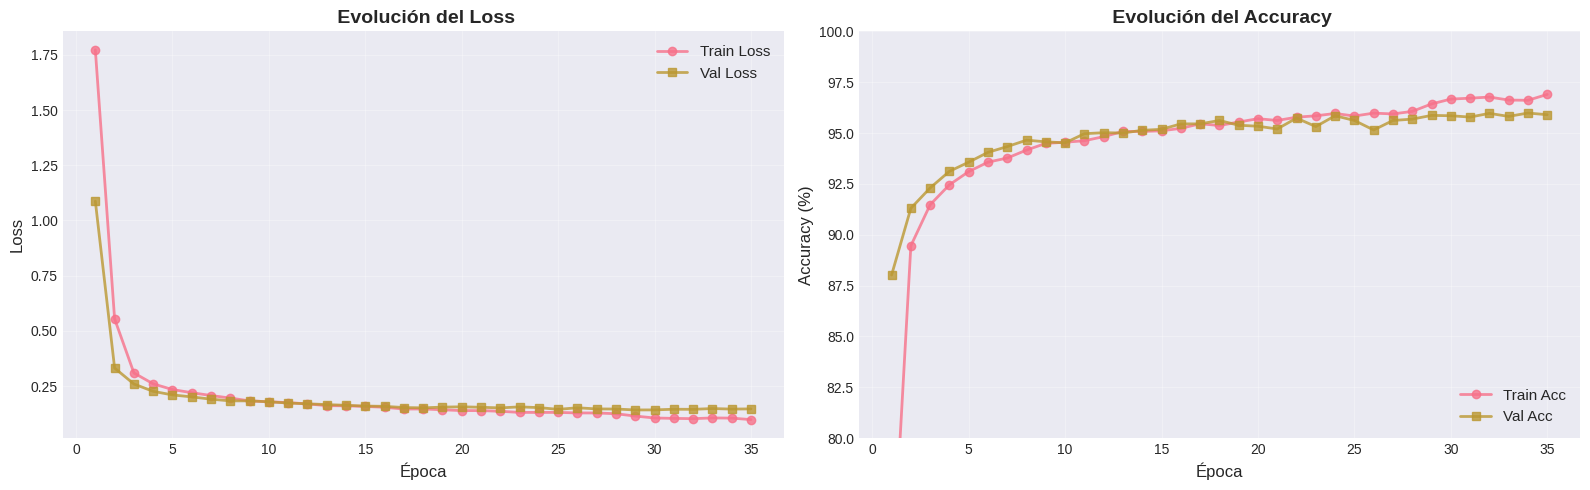

In [24]:
# ==============================================================================
# 21: Visualización de curvas de aprendizaje
# ==============================================================================

# Creamos figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Eje X: épocas
epochs_range = range(1, len(history['train_loss']) + 1)

# ===== SUBPLOT 1: LOSS =====
ax1.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss',
         linewidth=2, markersize=6, alpha=0.8)
ax1.plot(epochs_range, history['val_loss'], 's-', label='Val Loss',
         linewidth=2, markersize=6, alpha=0.8)

# Configuración del subplot
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title(' Evolución del Loss', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# ===== SUBPLOT 2: ACCURACY =====
# Convertimos a porcentaje
train_acc_pct = [acc * 100 for acc in history['train_acc']]
val_acc_pct = [acc * 100 for acc in history['val_acc']]

ax2.plot(epochs_range, train_acc_pct, 'o-', label='Train Acc',
         linewidth=2, markersize=6, alpha=0.8)
ax2.plot(epochs_range, val_acc_pct, 's-', label='Val Acc',
         linewidth=2, markersize=6, alpha=0.8)

# Configuración del subplot
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title(' Evolución del Accuracy', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([80, 100])  # Rango típico para MNIST

# Ajustamos layout
plt.tight_layout()

# Guardamos figura
plot_path = os.path.join(PLOTS_DIR, 'training_curves.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f" Gráfica guardada: {plot_path}")

# Mostramos
plt.show()

# Resultados del Entrenamiento
Este entrenamiento muestra que KAN converge de manera estable y consistente con entrenamiento prolongado, manteniendo un equilibrio entre train y val accuracy, sin overfitting notable.
El modelo aprende de forma sostenida y mejora hasta las últimas épocas.
Refleja robustez y madurez del entrenamiento.

# **Conclusión**


El entrenamiento realizado durante **35 épocas** demuestra que la arquitectura **Kolmogorov–Arnold Network (KAN)** presenta un **comportamiento de aprendizaje estable, gradual y sostenido** a lo largo del tiempo. A pesar de que el proceso es **más prolongado** (388 segundos por época), el modelo logra una **precisión de validación del 95.97 %**, evidenciando una **convergencia progresiva sin signos de sobreajuste**.

La **reducción continua del *loss*** (de 0.178 a 0.0978) confirma que el modelo mejora de forma sistemática su capacidad de representación, mientras que el uso de un **scheduler adaptativo** y la correcta gestión de **checkpoints** garantizan la estabilidad del entrenamiento.

En conjunto, estos resultados reflejan que **KAN es una arquitectura robusta y confiable**, capaz de mantener un proceso de optimización prolongado con **buen equilibrio entre precisión y generalización**. Si bien su ritmo de aprendizaje es más lento comparado con métodos tradicionales como los **MLP**, la **consistencia y estabilidad de la convergencia** demuestran su potencial para capturar relaciones no lineales complejas en los datos, cumpliendo con los principios teóricos del teorema de Kolmogórov–Arnold.
